<a href="https://colab.research.google.com/github/pszemraj/ai-msgbot/blob/main/colab-notebooks/hyperparameters/analyze_gridsearch_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grid Search for Parameters

- optimal "text bot" hyperparamters are not really known, nor is there a right answer
- proposal: iterate through "reasonable" parameter ranges, record output, compute sentence coherence scoring on outputs
- evaluate results once finished

## formatting

In [1]:
from IPython.display import HTML, display

# colab formatting
def set_css():
    display(
        HTML(
            """
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  """
        )
    )


get_ipython().events.register("pre_run_cell", set_css)

## GPU / CPU status

In [2]:
from psutil import virtual_memory
import os

ram_gb = round(virtual_memory().total / (1024 ** 3), 1)
print("Runtime has {} gigs of memory and {} processors".format(ram_gb, os.cpu_count()))

Runtime has 51.0 gigs of memory and 8 processors


In [3]:
!nvidia-smi

Tue Oct 26 21:47:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# setup

In [4]:
!pip install -U -q pandas
!pip uninstall -y -q pyarrow
!pip install -U -q pyarrow
!pip install -U -q openpyxl
import pandas as pd

In [5]:
!pip3 install -q torch==1.9.1+cu111  -f https://download.pytorch.org/whl/torch_stable.html

In [6]:
%%capture
!pip install -U tqdm
!pip install clean-text

import gc
import os
import pprint as pp
import time
import warnings
from datetime import datetime
from os.path import join


from tqdm.auto import tqdm
from cleantext import clean

warnings.filterwarnings(action="ignore", message=".*gradient_checkpointing*")

In [7]:
!pip uninstall -y -q plotly
!pip install -U -q plotly
import plotly.express as px

In [8]:
def create_folder(directory):
    os.makedirs(directory, exist_ok=True)


def shorten_title(title_text, max_no=35):
    if len(title_text) < max_no:
        return title_text
    else:
        return title_text[:max_no] + "..."


def cleantxt_wrap(ugly_text):
    # a wrapper for clean text with options different than default

    # https://pypi.org/project/clean-text/
    cleaned_text = clean(
        ugly_text,
        fix_unicode=True,  # fix various unicode errors
        to_ascii=True,  # transliterate to closest ASCII representation
        lower=True,  # lowercase text
        no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
        no_urls=True,  # replace all URLs with a special token
        no_emails=True,  # replace all email addresses with a special token
        no_phone_numbers=True,  # replace all phone numbers with a special token
        no_numbers=False,  # replace all numbers with a special token
        no_digits=False,  # replace all digits with a special token
        no_currency_symbols=True,  # replace all currency symbols with a special token
        no_punct=True,  # remove punctuations
        replace_with_punct="",  # instead of removing punctuations you may replace them
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        replace_with_number="<NUM>",
        replace_with_digit="0",
        replace_with_currency_symbol="<CUR>",
        lang="en",  # set to 'de' for German special handling
    )

    return cleaned_text

### dropbox 


- [tutorial](https://python.plainenglish.io/automate-your-pdf-upload-to-dropbox-python-script-bdacc2c721f6)
- [api docs](https://dropbox-sdk-python.readthedocs.io/en/latest/api/dropbox.html?highlight=files_upload#dropbox.dropbox_client.Dropbox.files_upload)

In [9]:
dropbox_subfolder = "GPT text gen - Custom Model"  # @param {type:"string"}

In [10]:
!pip install -q dropbox
import dropbox

In [11]:
token = "7JM1V7L7-0kAAAAAAAAAAc1mKnyh-G-4YwfL2o9WNJ2Tdh2JJslf_U5IxGrgb-J-"

dbx = dropbox.Dropbox(token)
pp.pprint(dbx.users_get_current_account(), compact=True, indent=4)

FullAccount(account_id='dbid:AAAYVJX_n2JYa7yh6anfANmwSJ7qkr-u8Do', account_type=AccountType('pro', None), country='CH', disabled=False, email='peterszemraj@gmail.com', email_verified=True, is_paired=False, locale='en', name=Name(abbreviated_name='PS', display_name='Peter Szemraj', familiar_name='Peter', given_name='Peter', surname='Szemraj'), profile_photo_url='https://dl-web.dropbox.com/account_photo/get/dbaphid%3AAACl3aYwbYAysBHXpGdGBXZj6IYsXocikxc?size=128x128&vers=1628569648991', referral_link='https://www.dropbox.com/referrals/AAAVOEoeLmg4Nw7hRIA9Wsn8OMf2_EdGbik?src=app9-10920512', root_info=UserRootInfo(home_namespace_id='9560958', root_namespace_id='9560958'), team=NOT_SET, team_member_id=NOT_SET)


In [12]:
def get_size_mb(path2file, verbose=False):

    file_stats = os.stat(path2file)

    file_size_mb = {file_stats.st_size / (1024 * 1024)}
    if verbose:
        print(f"File Size in MegaBytes is {file_size_mb}")
    return round(list(file_size_mb)[0], 2)  # returns rounded to 2 decimals

In [13]:
from os.path import join, basename, dirname
import time, random
from google.colab import files


def put_in_dropbox(
    vm_path, subfolder=dropbox_subfolder, no_printout=True, ncalls=0, max_calls=3
):
    if ncalls > max_calls:
        return "failed saving to DropBox - {} tries".format(ncalls)
    elif get_size_mb(vm_path) > 155:
        files.download(vm_path)
        return "file size of {} too big to put in DB, downloading".format(
            basename(vm_path)
        )
    # for an item on the colab machine on path, upload to dropbox app folder at
    # subfolder/"filename"
    base_filename = basename(vm_path)
    db_path = "/{}/{}".format(subfolder, base_filename)
    try:
        with open(vm_path, "rb") as f:
            dbx.files_upload(f.read(), path=db_path, autorename=True, mute=no_printout)
    except:
        print(
            "WARNING - unable to post in dropbox, retry no. {} - ".format(ncalls + 1),
            datetime.now(),
        )
        time.sleep(random.randint(1, 3))  # small delay before trying again
        put_in_dropbox(vm_path, ncalls=ncalls + 1)  # recursion for retrying

In [14]:
from datetime import date

# for filesaving purposes
today = date.today()
# Month abbreviation, day and year
today_string = today.strftime("%b-%d-%Y")
timestamp = datetime.now().strftime("%b-%d-%Y_%H-%M")

# Analysis

In [15]:
dl_link = "https://www.dropbox.com/s/6cmbaj23zx5jfwb/GPT-Peter774M-FINAL-gridsearch-Oct-26-2021_16-23.xlsx?dl=1"  # @param {type:"string"}

In [16]:
error_string = "<bro, there was an error. try again>"

df_analysis = pd.read_excel(dl_link, index_col=0).convert_dtypes()
df_analysis = df_analysis[df_analysis["model_response"] != error_string]
df_analysis.reset_index(drop=True, inplace=True)
df_analysis.info(verbose=True)  # overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            5000 non-null   Float64
 1   topk            5000 non-null   Int64  
 2   top_p           5000 non-null   Float64
 3   prompt          5000 non-null   string 
 4   speaker         5000 non-null   string 
 5   model_response  5000 non-null   string 
dtypes: Float64(2), Int64(1), string(3)
memory usage: 249.1 KB


assume the outputs are a single sentence and then use a [sentence-scoring algorithm on them](https://github.com/simonepri/lm-scorer) via `lm-scorer` package.

- [here](https://colab.research.google.com/github/simonepri/lm-scorer/blob/master/examples/lm_scorer.ipynb) is an example notebook

In [17]:
!pip install -q lm-scorer

import torch
from lm_scorer.models.auto import AutoLMScorer as LMScorer

# Available models
list(LMScorer.supported_model_names())
# => ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", distilgpt2"]

# Load model to cpu or cuda
device = "cuda:0" if torch.cuda.is_available() else "cpu"
batch_size = 1
scorer = LMScorer.from_pretrained("gpt2-large", device=device, batch_size=batch_size)
print("loaded - ", datetime.now())

loaded -  2021-10-26 21:48:44.253091


In [18]:
# example

# Compute sentence score as the geometric mean of tokens' probabilities
scorer.sentence_score("I like this package.", reduce="gmean")

0.009417757391929626

In [19]:
# create helper fn


def score_text_blob(gen_text: str, method="gmean", verbose=False):
    # for method 'mean',
    try:
        return scorer.sentence_score(gen_text, reduce=method)
    except:
        if verbose:
            print(f"failed computing scores for {gen_text}")
        return 0  # score sentences that failed at 0 - assumption = too undecipherable

### apply and see results

In [20]:
df_analysis.head()

temp  ...                                     model_response
0  0.51  ...  i have a lot of games that i work to do and ge...
1  0.51  ...  i'll be there 630-ish, but we can also do a bi...
2  0.51  ...                                  no worries man 👍👍
3  0.51  ...               there is like 2 cm of snow now ughhh
4  0.51  ...  at least from our literature review, the best ...

[5 rows x 6 columns]

In [21]:
import time

st = time.time()
df_analysis["model_response"] = df_analysis["model_response"].apply(str)
df_analysis["model_response"] = df_analysis["model_response"].apply(cleantxt_wrap)
df_analysis["geom_score"] = df_analysis["model_response"].apply(score_text_blob)
df_analysis["prod_score"] = df_analysis["model_response"].apply(
    score_text_blob, args=("prod",)
)
df_analysis["mean_score"] = df_analysis["model_response"].apply(
    score_text_blob, args=("mean",)
)
df_analysis["hmean_score"] = df_analysis["model_response"].apply(
    score_text_blob, args=("hmean",)
)
rt = (time.time() - st) / 60  # minutes
print(f"the total runtime was {rt} minutes")

the total runtime was 12.789010949929555 minutes


## basic - plotly

- [plotly express docs](https://plotly.com/python/plotly-express/)

In [22]:
fig_temp = px.histogram(
    df_analysis,
    x="hmean_score",
    color="topk",
    marginal="box",  # or violin, rug
    hover_data=df_analysis.columns,
    template="plotly_dark",
    title="Text Harmonic Mean Score Dist - various top_k values",
    height=720,
    width=int(720 * 1.613),
)
fig_temp.show()

In [23]:
fig_temp = px.histogram(
    df_analysis,
    x="prod_score",
    color="topk",
    marginal="box",  # or violin, rug
    hover_data=df_analysis.columns,
    template="ggplot2",
    title="Product Score Dist for different top_k values",
    log_y=True,
    height=720,
    width=int(720 * 1.613),
)
fig_temp.show()

In [24]:
df_analysis.columns

Index(['temp', 'topk', 'top_p', 'prompt', 'speaker', 'model_response',
       'geom_score', 'prod_score', 'mean_score', 'hmean_score'],
      dtype='object')

In [25]:
px.scatter_matrix(
    df_analysis,
    template="plotly_dark",
    dimensions=[
        "temp",
        "topk",
        "top_p",
        "geom_score",
        "mean_score",
        "hmean_score",
        "prod_score",
    ],
    height=1080,
    width=int(1080 * 1.613),
    color="prompt",
    title="scatter matrix - all quant vars",
)

## autoviz


In [26]:
save_av = True  # @param {type:"boolean"}

In [27]:
%%capture
!pip install -U autoviz

In [28]:
from autoviz.AutoViz_Class import AutoViz_Class

AV = AutoViz_Class()
filename = "for_autoviz.csv"

df_analysis.to_csv(filename, index=False)

Imported AutoViz_Class version: 0.0.85. Call using:
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 does not show plot but creates them and saves them in AutoViz_Plots directory in your local machine.


In [29]:
sep = ","
dft = AV.AutoViz(
    filename,
    sep=",",
    depVar="hmean_score",
    dfte=None,
    header=0,
    verbose=2,
    lowess=True,
    chart_format="svg",
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
)

Shape of your Data Set loaded: (5000, 10)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
Data Set Shape: 5000 rows, 9 cols
Data Set columns info:
* temp: 0 nulls, 50 unique vals, most common: {0.51: 100, 0.66: 100}
* topk: 0 nulls, 4 unique vals, most common: {50: 1250, 75: 1250}
* top_p: 0 nulls, 25 unique vals, most common: {0.74: 200, 0.82: 200}
* prompt: 0 nulls, 20 unique vals, most common: {'Have you done anything exciting lately?': 289, 'what she orda?': 281}
* speaker: 0 nulls, 14 unique vals, most common: {'jonathan': 390, 'lucia pasara': 370}
* model_response: 0 nulls, 3094 unique vals, most common: {'imagine thinking cgi exists': 49, 'no i do not unfortunately': 47}
* geom_score: 0 nulls, 3093 unique vals, most common: {0.0008952185744419: 49, 0.0013426389778032: 47}
* prod_score: 0 nulls, 2701 unique vals, most common: {0.0: 635, 4.60791299980321e-22: 49}
* mean_score: 0 nulls, 3094 unique vals, most common

In [30]:
import shutil
from pathlib import Path

autopath = Path("/content/AutoViz_Plots")
av_arc = "GPT-Peter Hyperparam Opt_autoviz_plots_{}".format(timestamp)
shutil.make_archive(av_arc, "gztar", autopath)

if save_av:
    put_in_dropbox(av_arc + ".tar.gz")

## sweetviz

In [31]:
df_analysis.columns

Index(['temp', 'topk', 'top_p', 'prompt', 'speaker', 'model_response',
       'geom_score', 'prod_score', 'mean_score', 'hmean_score'],
      dtype='object')

In [32]:
!pip install -q sweetviz
import sweetviz as sv

df_sv = df_analysis.copy().convert_dtypes()

feature_config = sv.FeatureConfig(
    skip=[
        "prompt",
        "speaker",
        "model_response",
    ],
    force_num=["temp", "topk", "top_p", "geom_score", "hmean_score"],
)


df_sv = df_sv[["temp", "topk", "top_p", "geom_score", "hmean_score"]]

df_sv = df_sv.astype(float)

df_sv["model_response"] = df_analysis["model_response"].astype(str)
df_sv["model_response"] = df_sv["model_response"].astype("string")

df_sv["prompt"] = df_analysis["prompt"].astype(str)
df_sv["prompt"] = df_sv["prompt"].astype("string")

df_sv["speaker"] = df_analysis["speaker"].astype(str)
df_sv["speaker"] = df_sv["speaker"].astype("string")

df_sv.info()
# df_sv["topk"] = df_sv["topk"].astype(float)
# df_sv["topk"] = df_sv["topk"].astype(float)
# arameters are skip, force_cat, force_num and force_text.

     |████████████████████████████████| 15.1 MB 9.8 MB/s 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            5000 non-null   float64
 1   topk            5000 non-null   float64
 2   top_p           5000 non-null   float64
 3   geom_score      5000 non-null   float64
 4   hmean_score     5000 non-null   float64
 5   model_response  5000 non-null   string 
 6   prompt          5000 non-null   string 
 7   speaker         5000 non-null   string 
dtypes: float64(5), string(3)
memory usage: 312.6 KB


In [33]:
my_report = sv.analyze(df_sv, target_feat="hmean_score")

sv_eda_name = "GPT-Peter Hyperparam Opt-SWEETVIZ-EDA-{}.html".format(timestamp)

my_report.show_html(
    filepath=sv_eda_name,
    layout="vertical",
)  # Default arguments will generate to "SWEE

                                             |          | [  0%]   00:00 -> (? left)

Report GPT-Peter Hyperparam Opt-SWEETVIZ-EDA-Oct-26-2021_21-48.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



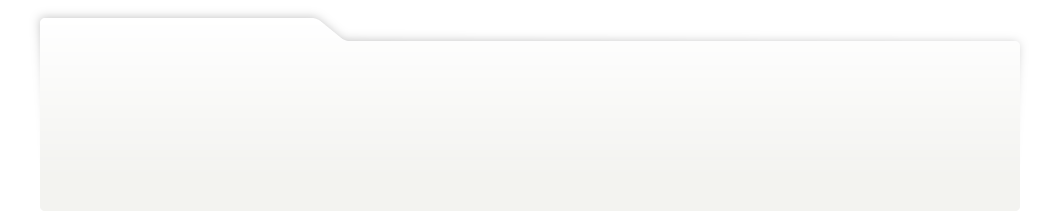
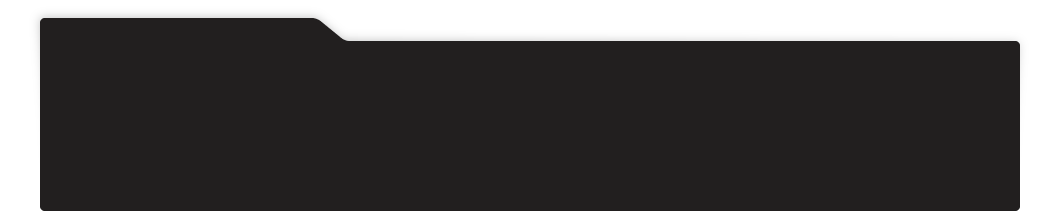
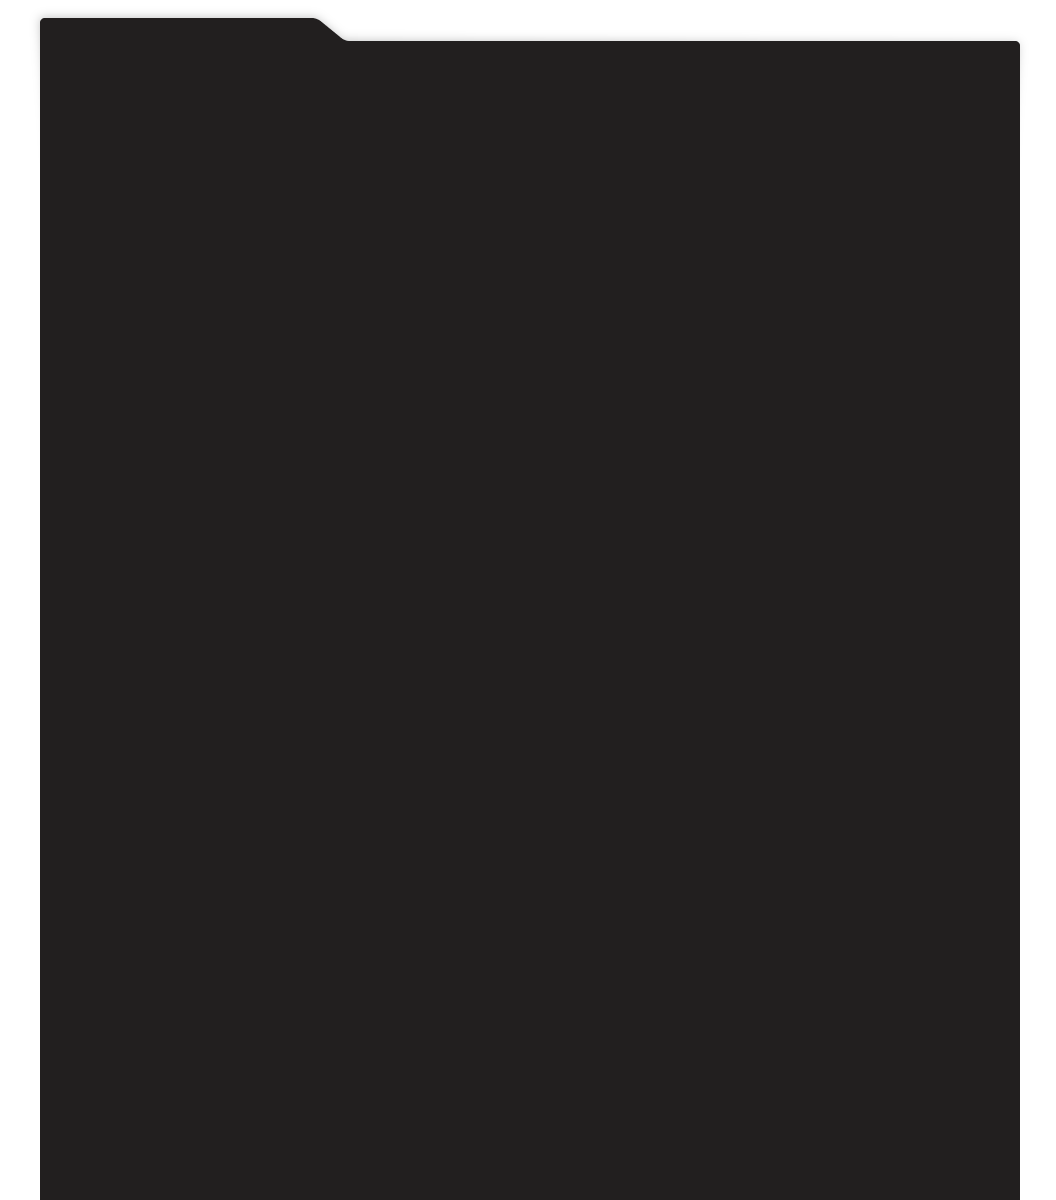
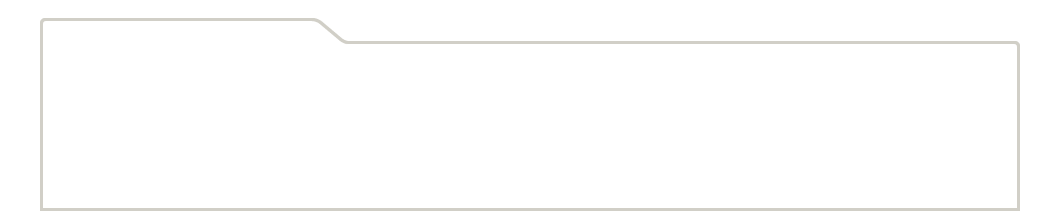
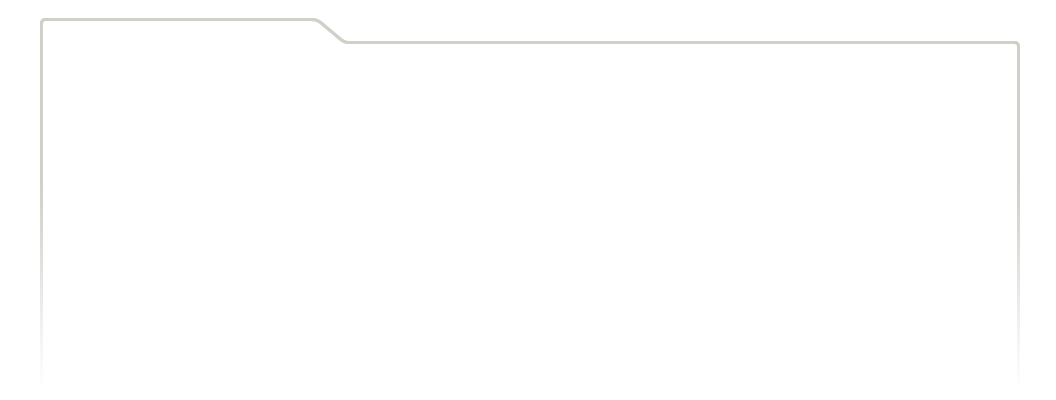
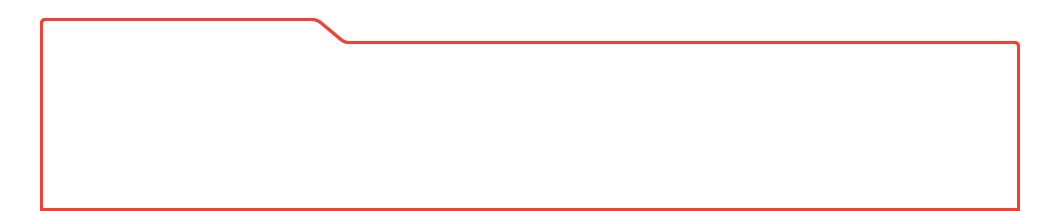
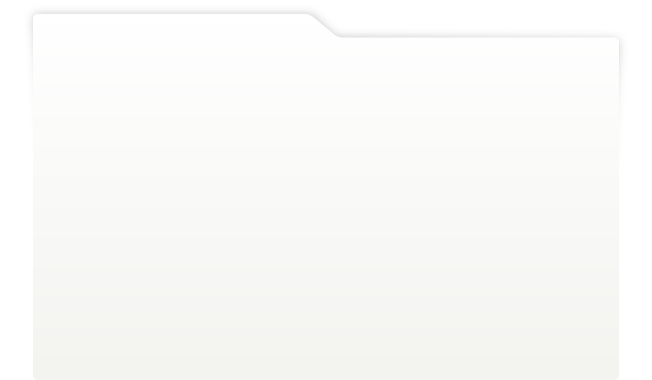
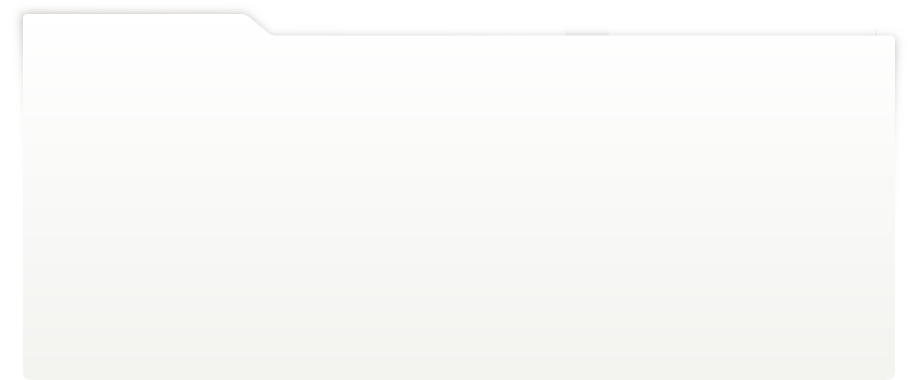
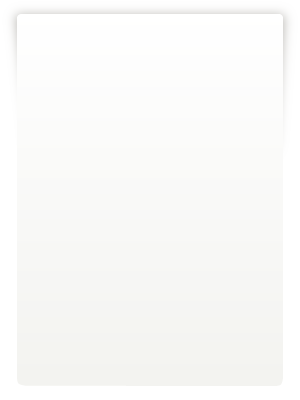
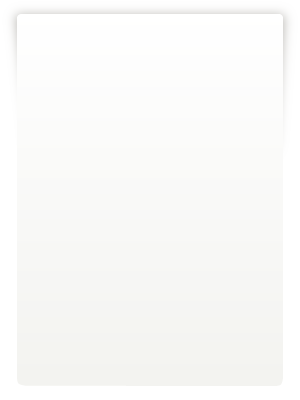
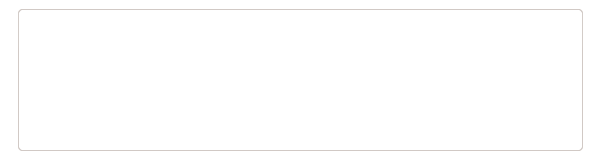
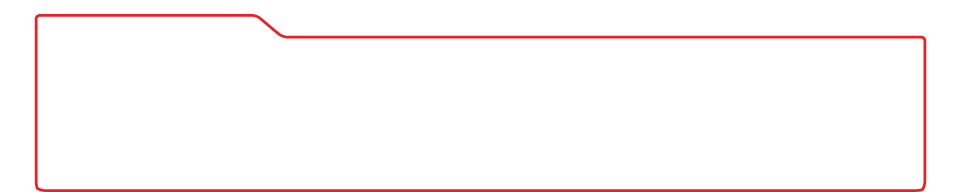
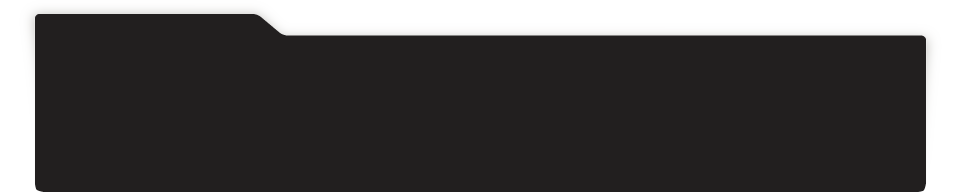
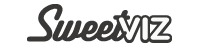
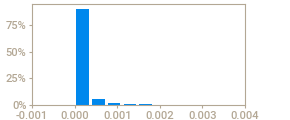
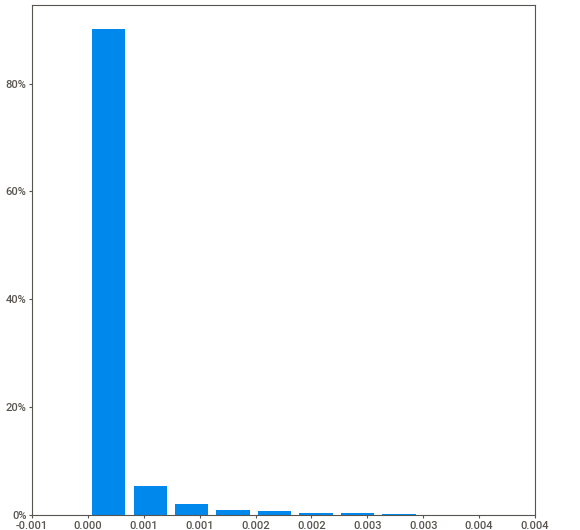
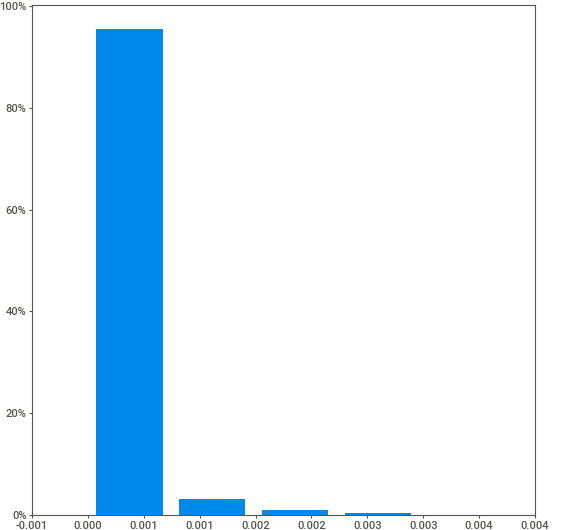
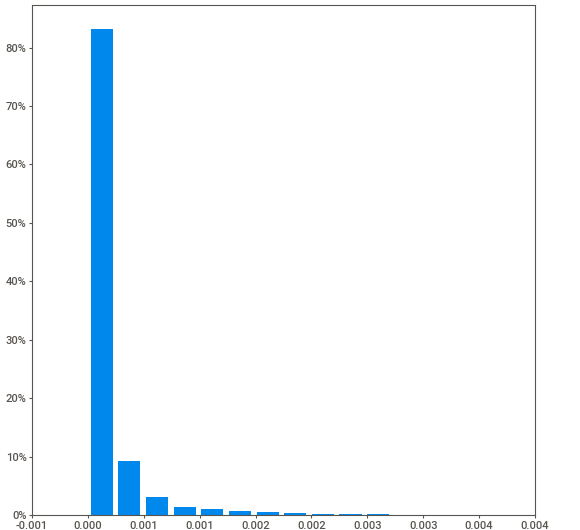
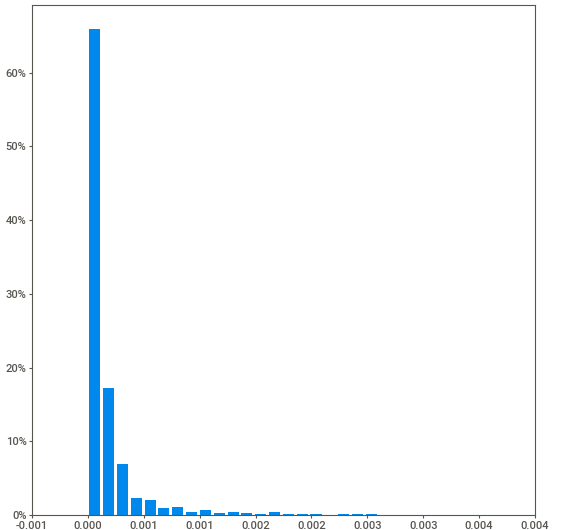
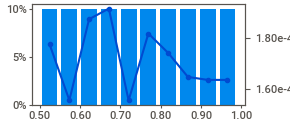
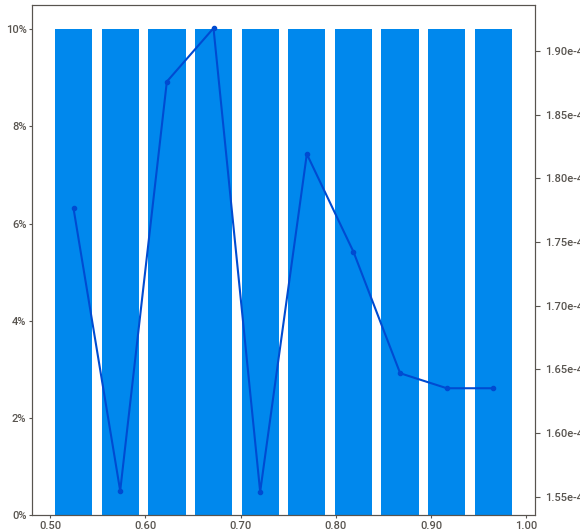
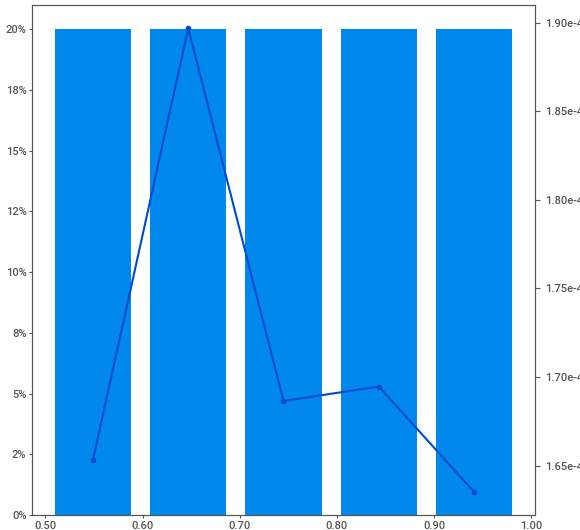
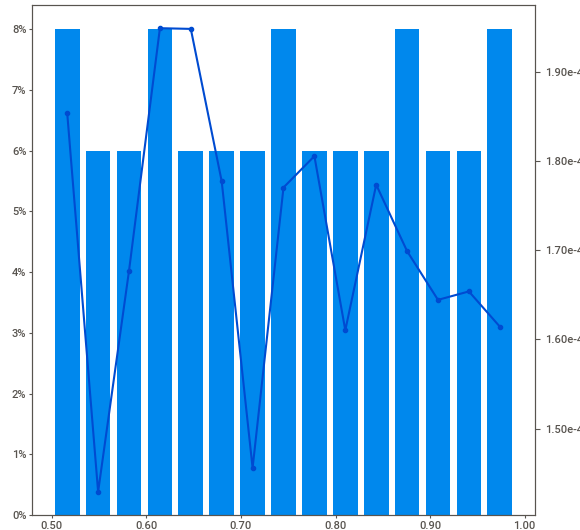
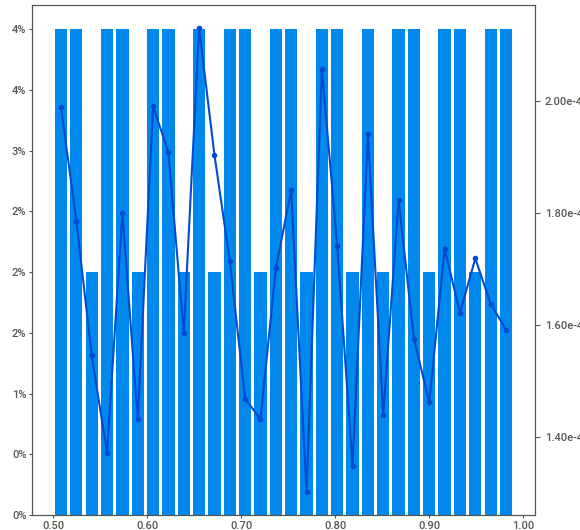
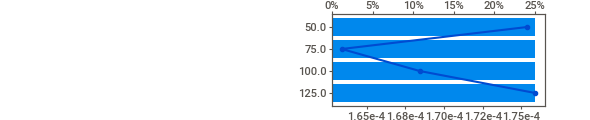
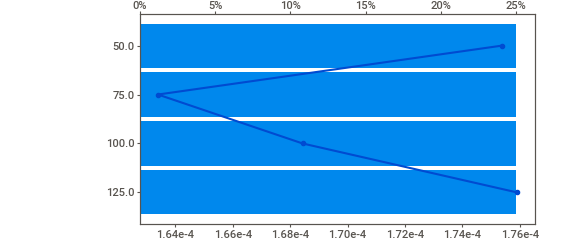
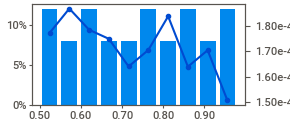
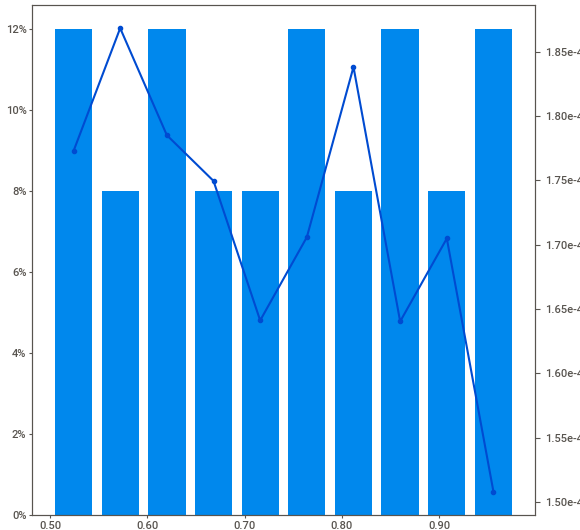
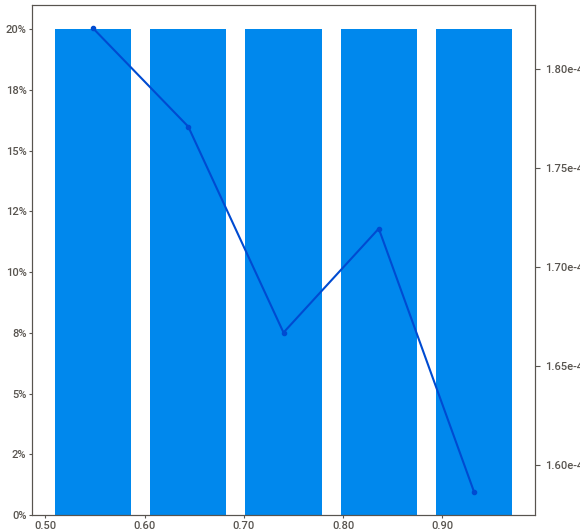
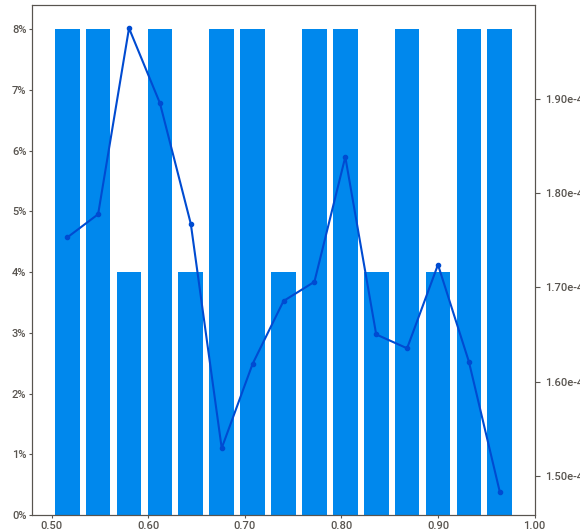
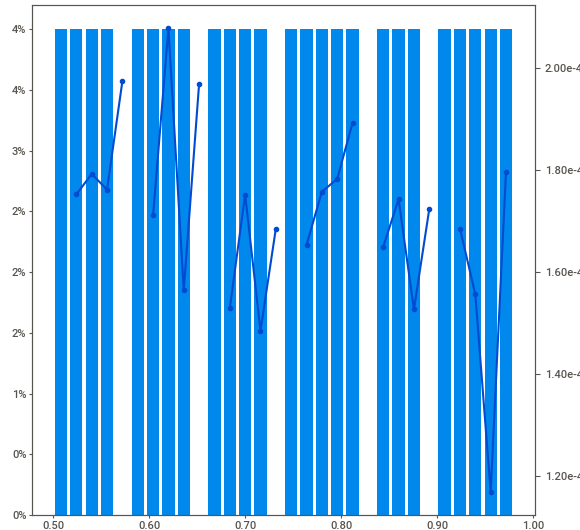
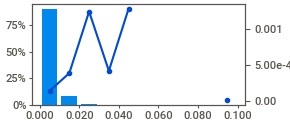
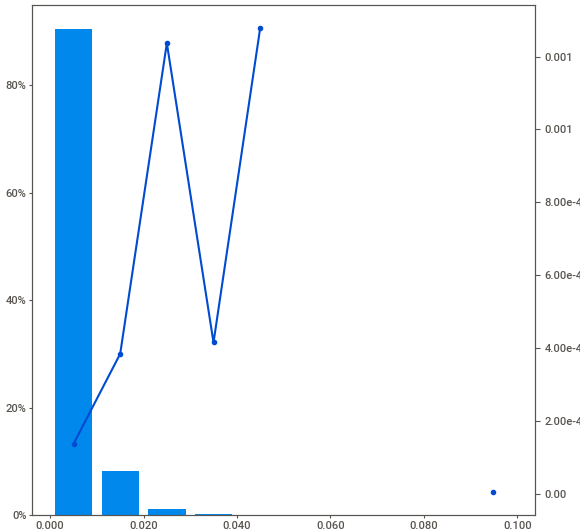
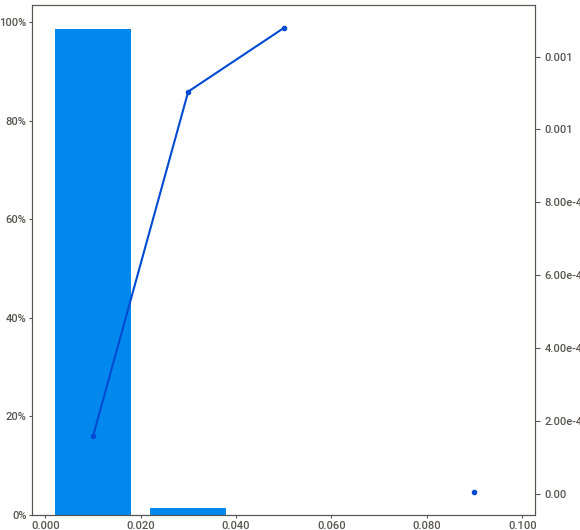
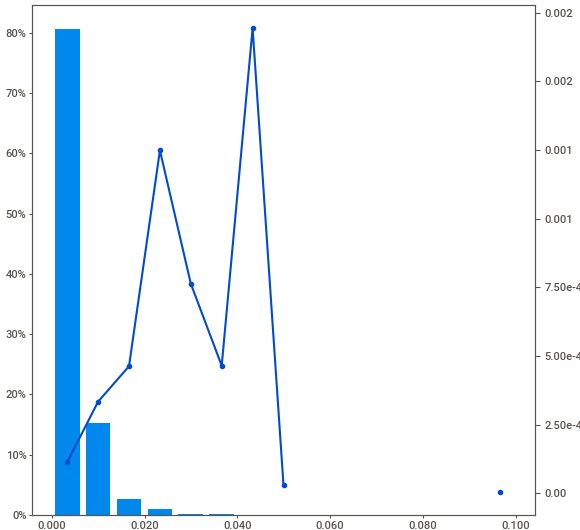
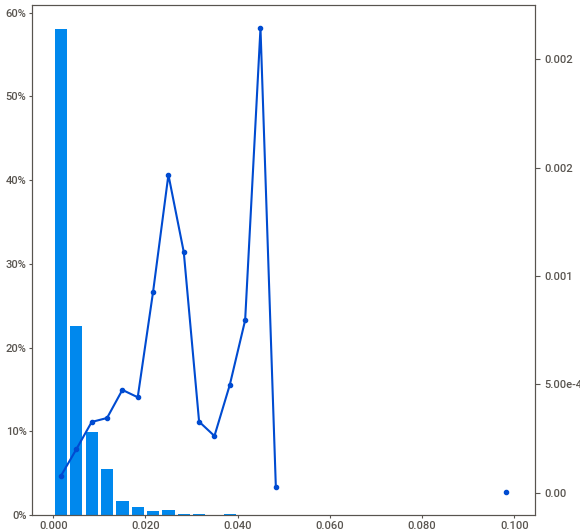
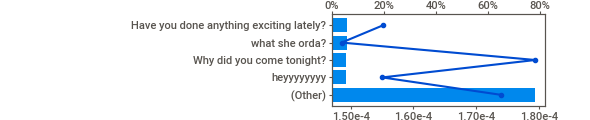
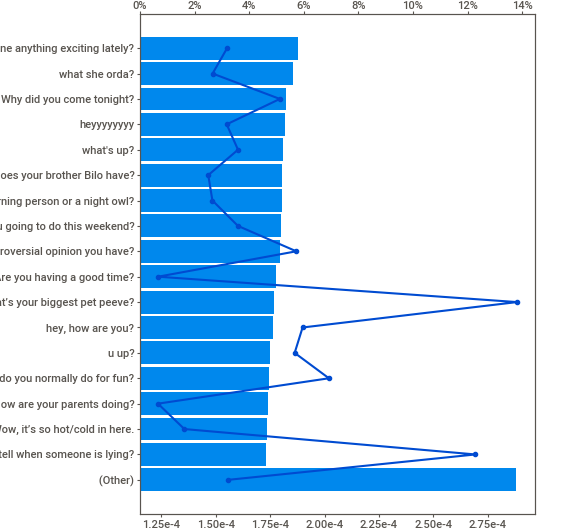
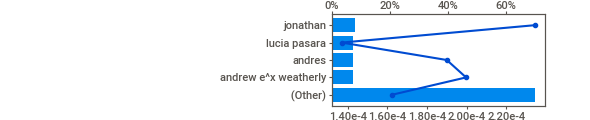
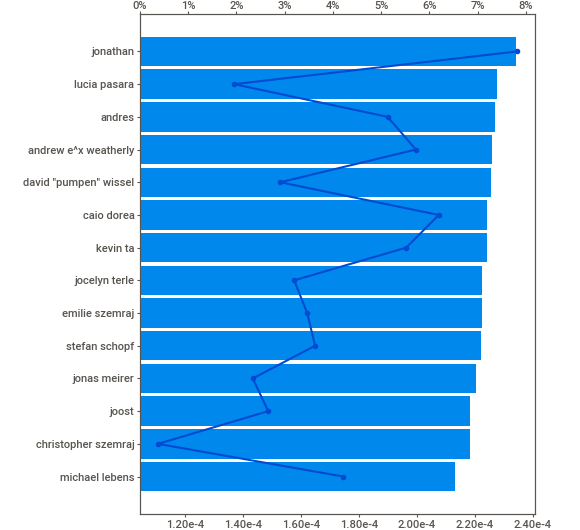
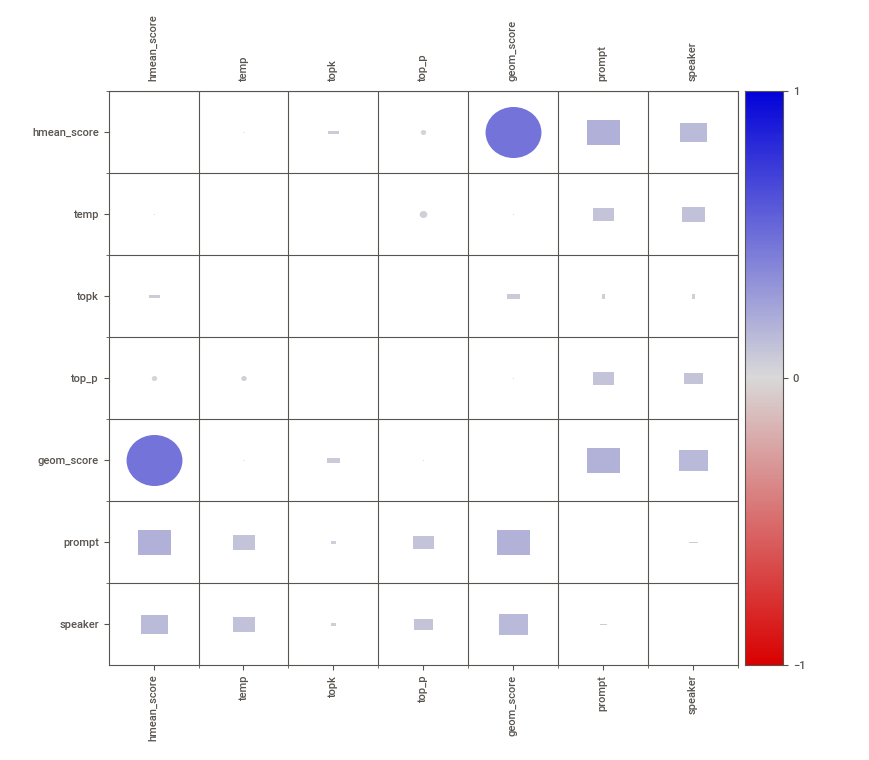
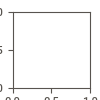

In [34]:
from IPython.display import HTML

HTML(sv_eda_name)

In [35]:
put_in_dropbox(sv_eda_name)

## data table + export 

In [36]:
from google.colab import *


data_table.DataTable(df_analysis, num_rows_per_page=10)

In [37]:
df_analysis.reset_index(drop=True, inplace=True)
data_header = "GPT-Peter Hyperparam Analysis w Metrics - {}".format(timestamp)
df_analysis.to_excel(data_header + ".xlsx")
put_in_dropbox(data_header + ".xlsx")

df_analysis.to_feather(data_header + ".ftr")
put_in_dropbox(data_header + ".xlsx")

## pandas profiling 

In [38]:
gc.collect()

55220

In [39]:
!pip uninstall -y -q pandas-profiling
!pip install -U -q pandas-profiling

import numpy as np
from pandas_profiling import ProfileReport

     |████████████████████████████████| 261 kB 12.6 MB/s 
     |████████████████████████████████| 3.1 MB 72.8 MB/s 
     |████████████████████████████████| 102 kB 14.2 MB/s 
     |████████████████████████████████| 10.1 MB 66.0 MB/s 
     |████████████████████████████████| 596 kB 66.6 MB/s 
     |████████████████████████████████| 62 kB 991 kB/s 
     |████████████████████████████████| 675 kB 56.3 MB/s 
     |████████████████████████████████| 812 kB 62.9 MB/s 
     |████████████████████████████████| 28.5 MB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.9.1+cu111 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompati

In [40]:
gc.collect()

50

In [41]:
df_profile = df_analysis[
    [
        "temp",
        "topk",
        "top_p",
        "prod_score",
        "mean_score",
        "prompt",
        "speaker",
        "hmean_score",
        "model_response",
    ]
]
profile = ProfileReport(
    df_profile,
    dark_mode=True,
    title="GPT-Peter Hyperparam Opt (Sentence Score)",
    minimal=True,
)


profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
pd_eda_name = "GPT-Peter Hyperparam Opt-EDA-{}.html".format(timestamp)
profile.to_file(pd_eda_name)

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
put_in_dropbox(pd_eda_name)
print("saved - ", datetime.now())

saved -  2021-10-26 22:02:33.807219
